<a href="https://colab.research.google.com/github/BryanCoboF/dataScienceStudy/blob/main/dataScienceForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# Librerias
from collections import defaultdict, Counter
from tabulate import tabulate
import pandas as pd
import numpy as np
import xlrd
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from scipy import stats
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split



In [2]:
from google.colab import files
from google.colab import drive

drive.mount('/content/drive') # Permite ingresar a drive desde las carpetas de drive

pathPromedios = "/content/drive/MyDrive/PB/Mirasilv/INGRESO SEMANAL-INV-2.xlsx"
pathIndividuales ="/content/drive/MyDrive/PB/IS/ArbolesCompleto.xlsx"

df = pd.read_excel(pathPromedios) # Carga el excel de datos de proyeccion, si se necesita cambiar el archivo se debe modificar el link
dfInd = pd.read_excel(pathIndividuales)


Mounted at /content/drive


In [37]:
#df.columns
dfInd.columns

Index(['Lote-Sitio', 'Cód. Lote', 'Nombre del Sitio', 'Convenio-Folio',
       'No. de Resolución-Contrato', 'Fecha de Medición', 'NS. de Medición',
       'Edad en Meses', 'Edad en Años', 'Cód. Experimento', 'Cód. Tratamiento',
       'NS. Tratamiento', 'Núm. de Repetición', 'Especie', 'Árbol', 'Eje',
       'Línea', 'Posición', 'Diám./DAP (cm)', 'Altura Total (m)',
       'Altura Comercial (m)', 'Código de Forma y Defecto',
       'Código de Sanidad', 'Raleado', 'ID. Lote', 'Año medicion',
       'Mes medicion', 'Parcela'],
      dtype='object')

5096


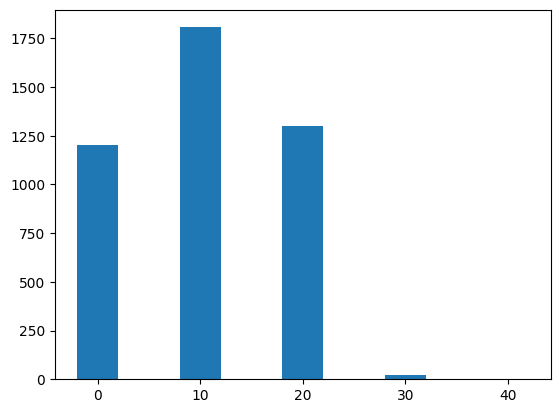

In [25]:
dfRes = df[['Nombre del Sitio','ID. Lote','NS. Tratamiento','Árboles Originales (pa.)','Edad en Meses','Área Neta', 'Supervivencia (%)', 'Ejes Vivos (Ha)','DAP (cm)','Altura Total (m)', 'Altura Comercial (m)','Área Basal', 'Área Neta de Lote', 'Área Total de Lote','UTM (Zona)', 'UTM (Este)', 'UTM (Norte)', 'Latitud', 'Longitud']].copy()
colAreaNeta = np.array(df['Área Neta de Lote'])
colSitio = np.array(df['Nombre del Sitio'])
colEdad = np.array(df['Edad en Meses'])
colDap = np.array(df['DAP (cm)'])
colEjesVivos = np.array(df['Ejes Vivos (Ha)'])
colAT = np.array(df['Altura Total (m)'])
colAC = np.array(df['Altura Comercial (m)'])


redondeoDap = lambda dap1 : dap1 // 10 * 10


histoRedondeoDap = Counter(redondeoDap(dap1) for dap1 in colDap)
print(sum(histoRedondeoDap.values()))
plt.bar(histoRedondeoDap.keys(), histoRedondeoDap.values(), 4)

plt.show()

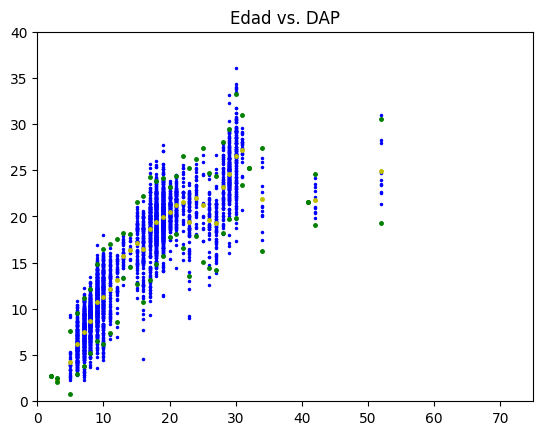

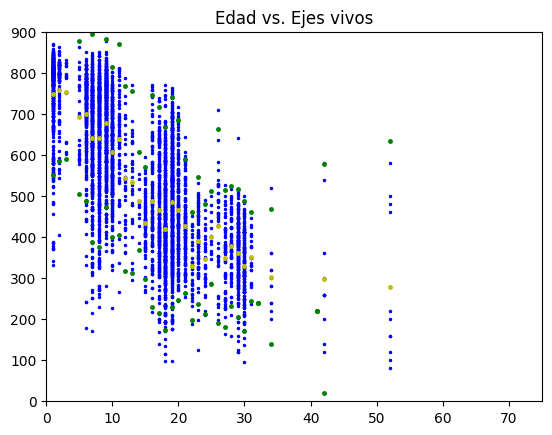

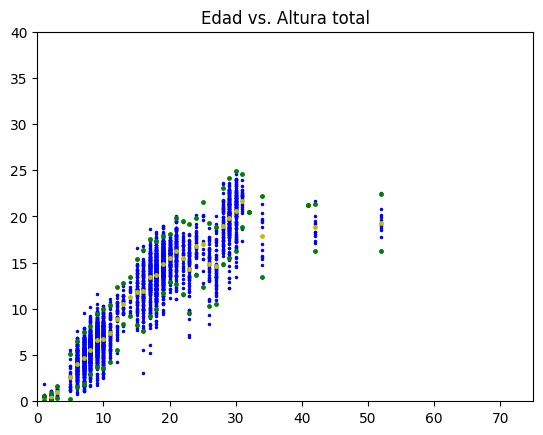

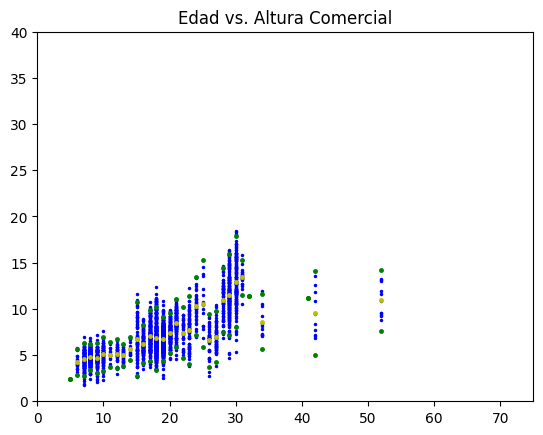

In [6]:
# Analsis de variables en edades de interes

def valoresInteres(edadDes, vecEdad,vecInteres, vecAreasNetas):
  #Funcion que obtiene todos los datos de las edades de interes definidas por el usuario
  edadInteres = np.array([])
  varInteres = np.array([])
  areasInteres = np.array([])
  #Obtencion de datos de interes (en la edad deseada)
  for age, _ in enumerate(vecEdad):
    if vecEdad[age] == edadDes and vecInteres[age] > 0:
      edadInteres = np.append(edadInteres, vecEdad[age])
      varInteres = np.append(varInteres, vecInteres[age])
      areasInteres = np.append(areasInteres, vecAreasNetas[age])
  return edadInteres, varInteres, areasInteres

def graficaDispersion(edadV, varGraficar, varPond, variableAnalisis, rangosGraf, edadD, rangoVariable):
    #Funcion que grafica la variable de interes en las edades deseadas
    # edadV - es vector que recopila todos los datos iguales a la edad de interes analizada
    # varGraficar -  es la variable que se va a graficar en el eje Y
    # varPond - es el promedio ponderado calculado de solo los datos de cada edad deseada
    # variableAnalisis - es el string de la variable a graficar para el titulo
    # rangos - son los rangos que tendran los ejes de la grafica dependiendo de la variable
    # edadD - es la edad deseada para graficar el punto con el ponderado de la variable
    # rangoVariable es el rango calculado por cada edad
    plt.plot(edadV,varGraficar, 'b.', markersize = 3)
    #plt.plot(edadD, varPond, 'r.', markersize = 5) #Promedio ponderado
    plt.plot(edadD, np.average(varGraficar), 'y.', markersize = 5) # Promedio Normal
    plt.plot(edadD, np.average(varGraficar) + 2 * np.std(varGraficar), 'g.', markersize = 5) # Promedio + 2 desviacion
    plt.plot(edadD, np.average(varGraficar) - 2 * np.std(varGraficar), 'g.', markersize = 5) # Promedio - 2 desviacion
    #modaVarInteres = stats.mode(varGraficar)
    #plt.plot(edadD, modaVarInteres[0], 'g*', markersize = 5)
    #plt.annotate(round(varPond,1), xy=(edadD, varPond), xytext=(4,-4),textcoords='offset points', fontsize=5)
    plt.title("Edad vs. " + variableAnalisis)
    plt.axis(rangosGraf)
    #plt.show()


def rangoVar(varInteres):
  shapeVec = np.shape(varInteres)
  if shapeVec[0]>0:
    rangoRes = np.max(varInteres) - np.min(varInteres)
    return rangoRes





def ponderaVal(areaNeta, variablePond):
  #Funcion que obtiene el promedio ponderado de la variable escogida en la edad de interes
  if np.sum(areaNeta)>0:
    ponderacion = np.sum([area * variable for area, variable in zip(areaNeta, variablePond) if area>0 and variable>0])/np.sum(areaNeta)
  else:
    ponderacion = 0
  return  ponderacion


#Vector edades de interes

edadesGrafica = [1*c for c in range(1,60)]



variables = ["DAP", "Ejes vivos", "Altura total", "Altura Comercial"]
for vari in variables:
  for ages in edadesGrafica: # Define los rangos de interes
    if ages in colEdad:
      if vari == "DAP":
        varX, varY, vecAreasInteres = valoresInteres(ages,colEdad, colDap, colAreaNeta)
        rangoPorEdad = rangoVar(varY)
        rangoGraf = [0,75,0,40]
      if vari == "Altura total":
        varX, varY, vecAreasInteres = valoresInteres(ages,colEdad, colAT, colAreaNeta)
        rangoPorEdad = rangoVar(varY)
        rangoGraf = [0,75,0,40]
      if vari == "Altura Comercial":
        varX, varY, vecAreasInteres = valoresInteres(ages,colEdad, colAC, colAreaNeta)
        rangoPorEdad = rangoVar(varY)
        rangoGraf = [0,75,0,40]
      if vari == "Ejes vivos":
        varX, varY, vecAreasInteres = valoresInteres(ages,colEdad, colEjesVivos, colAreaNeta)
        rangoPorEdad = rangoVar(varY)
        rangoGraf = [0,75,0,900]

      if len(vecAreasInteres) > 0:
        graficaDispersion(varX, varY, ponderaVal(vecAreasInteres, varY), vari, rangoGraf,ages,rangoPorEdad)
  plt.show()

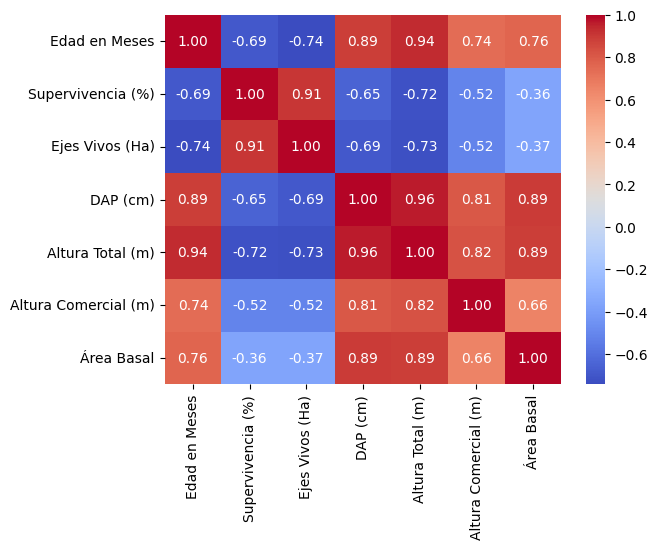

In [ ]:
#Correlacion de datos de interes
def matrizCorr(dfCorrelacion):
  matrizCorrelacion = dfCorrelacion.corr()
  sns.heatmap(matrizCorrelacion, annot=True, cmap='coolwarm', fmt=".2f")


dfCorre = df[['Edad en Meses','Supervivencia (%)', 'Ejes Vivos (Ha)','DAP (cm)','Altura Total (m)', 'Altura Comercial (m)','Área Basal', ]].copy()

#Seleccion de variables a analizar correlacion en un data frame
#dfResumen = dataFrameResumen(df)

matrizCorr(dfCorre)

Desea estimar los datos de:
 1)Arboles individuales 
 2) PPM 
 Ingrese el numero del criterio con el que quiere entrenar: 2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have 

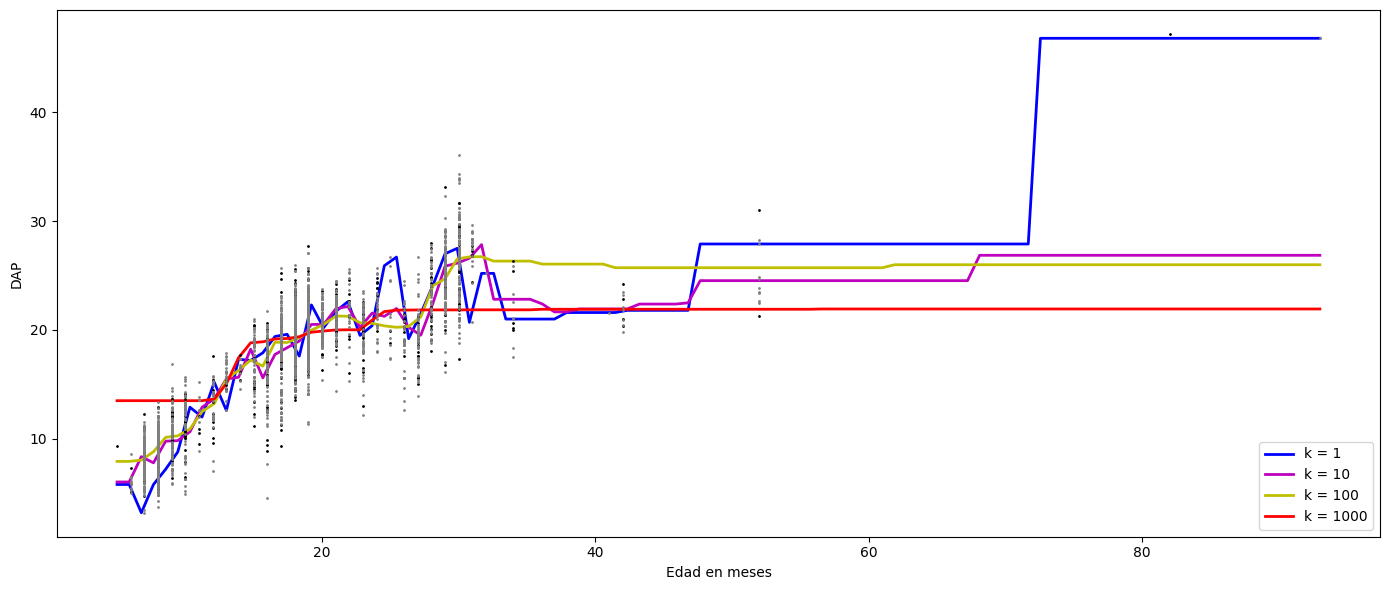

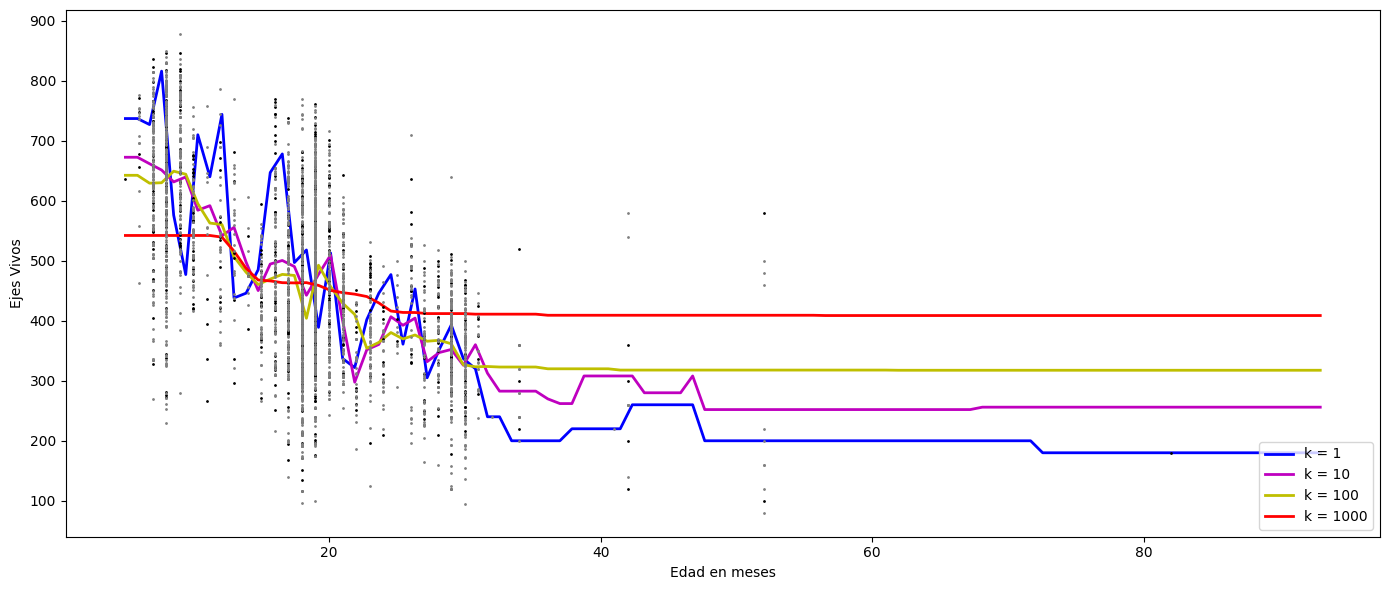

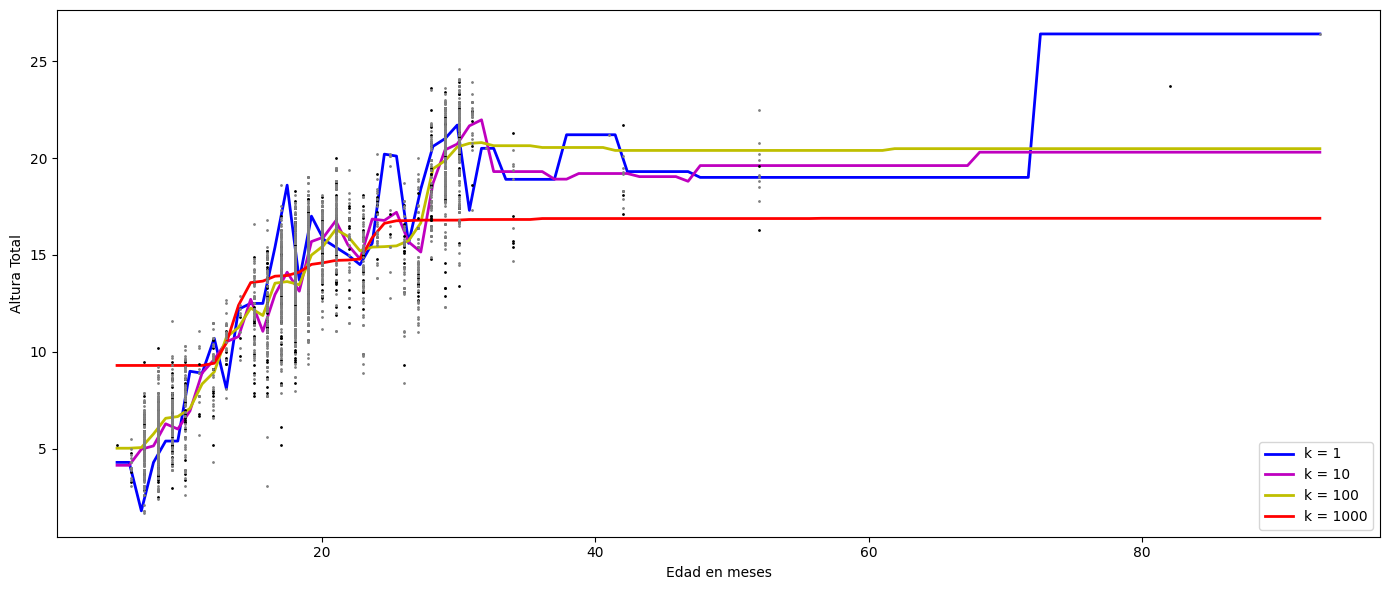

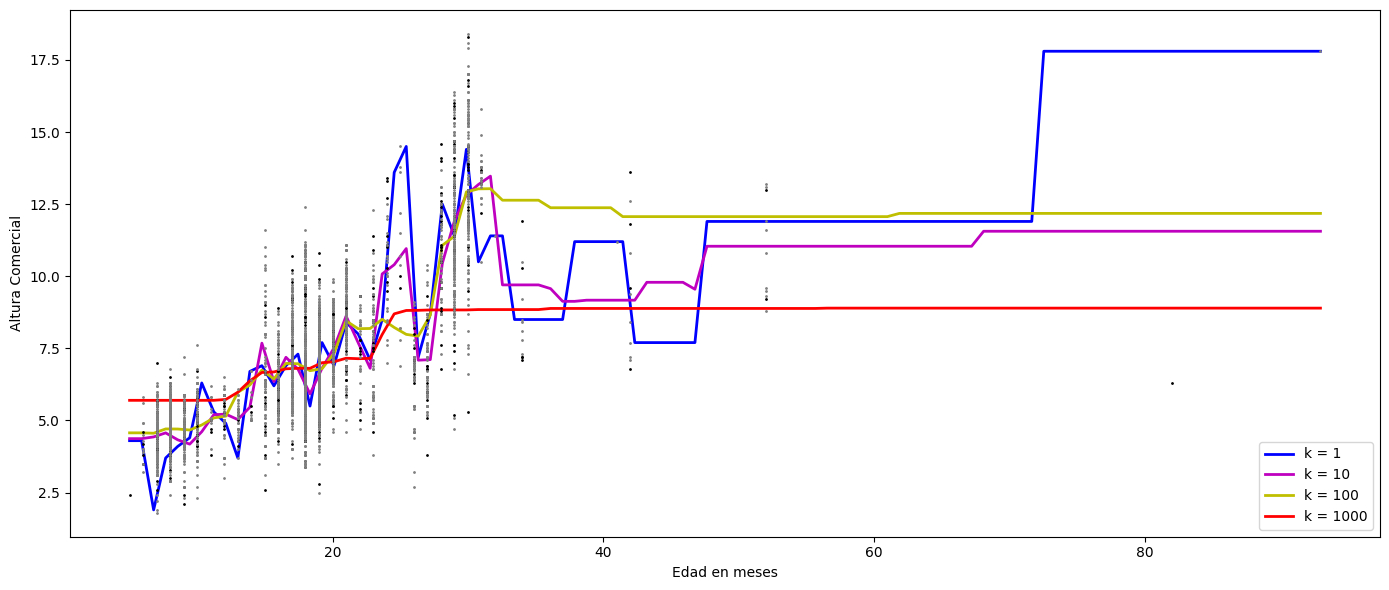

In [81]:
# Regresion K vecinos cercanos KNN
# Segun el criterio de analisis (arboles individuales o PPM), se hace la regresion KNN para las variables DAP, AT, AC y EV con respecto a la edad en meses



def trainTestValues(xVal,yVal,kMin,kMax, trainSizer, estadoAleatorio):
  # Funcion que divide los valores de las variables de interes entre un vector para entrenamiento y otro para testeo
  #trainSizer entre 0 - 1
  # estadoAleatorio es valor entero
  xTrain, xTest, yTrain, yTest = train_test_split(xVal, yVal, train_size=trainSizer,random_state=estadoAleatorio)
  kList = np.linspace(kMin, kMax, kMax)
  return xTrain, xTest, yTrain, yTest, kList


def KNNRegresion (kLista, xTrainer, yTrainer, xTester, yTester, kPlotValues, plotColors, predictor, varString):
  # kPlotValues son los valores de K que se quiere graficar, debe ser del mismo tamaño que plotColors
  # predictor es el df[[]] object original, en este caso la edad.
  # varString es el nombre de la variable a analizar para graficar
  fig, ax = plt.subplots(figsize=(14,6))
  j=0
  for k in kLista:
    modelo = KNeighborsRegressor(n_neighbors=int(k)) # Definicion del modelo de regresion dependiendo de k
    modelo.fit(xTrainer, yTrainer)  # Ajuste del modelo
    if k in kPlotValues: #Graficacion del modelo
      valoresX = np.linspace(predictor.min(), predictor.max(), 100)
      prediccionesY = modelo.predict(valoresX)
      ax.plot(valoresX, prediccionesY, "-", label = f'k = {int(k)}', linewidth = 2, color = plotColors[j])
      j+=1
  ax.legend(loc='lower right', fontsize=10)
  ax.plot(xTester,yTester,'.', label="Test", color = 'k',markersize = 2)
  ax.plot(xTrainer,yTrainer,'.', label="Train", color = 'gray',markersize = 2)
  ax.set_xlabel('Edad en meses', fontsize = 10)
  ax.set_ylabel(varString, fontsize = 10)
  plt.tight_layout()



kPlots = [1,10,100,1000]
coloresPlot = ['b','m','y','r']

print("Desea estimar los datos de:\n 1)Arboles individuales \n 2) PPM ")
criterioEstimacion = input(" Ingrese el numero del criterio con el que quiere entrenar: ")


if criterioEstimacion == "1":
  dfResInd = dfInd[['Edad en Meses','Diám./DAP (cm)','Altura Total (m)', 'Altura Comercial (m)']].copy()
  dfSinNAInd = dfResInd.dropna()
  dfSinNAInd = dfSinNAInd[dfSinNAInd.applymap(lambda x: not isinstance(x, str)).all(axis=1)]
  dfSinNAInd = dfSinNAInd[dfSinNAInd.applymap(lambda x: x>=0 and x<=100).all(axis=1)]
  edadKNN = dfSinNAInd[['Edad en Meses']]  # variable predictora
  dapKNN = dfSinNAInd['Diám./DAP (cm)'] #variable respuesta
  atKNN = dfSinNAInd['Altura Total (m)'] #variable respuesta
  acKNN = dfSinNAInd['Altura Comercial (m)'] #variable respuesta
  titGraf = ['DAP', 'Ejes Vivos', 'Altura Total', 'Altura Comercial']
  xTr, xTe, yTr, yTe, kVec  = trainTestValues(edadKNN, dapKNN, 1, 1000, 0.7, 42)
  KNNRegresion(kVec, xTr, yTr, xTe, yTe, kPlots, coloresPlot,edadKNN,titGraf[0])
  xTr, xTe, yTr, yTe, kVec  = trainTestValues(edadKNN, atKNN, 1, 1000, 0.7, 42)
  KNNRegresion(kVec, xTr, yTr, xTe, yTe, kPlots, coloresPlot,edadKNN,titGraf[2])
  xTr, xTe, yTr, yTe, kVec  = trainTestValues(edadKNN, acKNN, 1, 1000, 0.7, 42)
  KNNRegresion(kVec, xTr, yTr, xTe, yTe, kPlots, coloresPlot,edadKNN,titGraf[3])


if criterioEstimacion == "2":
  dfResPPM = df[['Nombre del Sitio','ID. Lote','Edad en Meses', 'Ejes Vivos (Ha)','DAP (cm)','Altura Total (m)', 'Altura Comercial (m)']].copy()
  dfSinNAPPM = dfResPPM.dropna()
  edadKNN = dfSinNAPPM[['Edad en Meses']]  # variable predictora
  dapKNN = dfSinNAPPM['DAP (cm)'] #variable respuesta
  ejesKNN = dfSinNAPPM['Ejes Vivos (Ha)'] #variable respuesta
  atKNN = dfSinNAPPM['Altura Total (m)'] #variable respuesta
  acKNN = dfSinNAPPM['Altura Comercial (m)'] #variable respuesta
  titGraf = ['DAP', 'Ejes Vivos', 'Altura Total', 'Altura Comercial']
  xTr, xTe, yTr, yTe, kVec  = trainTestValues(edadKNN, dapKNN, 1, 1000, 0.7, 42)
  KNNRegresion(kVec, xTr, yTr, xTe, yTe, kPlots, coloresPlot, edadKNN, titGraf[0])
  xTr, xTe, yTr, yTe, kVec  = trainTestValues(edadKNN, ejesKNN, 1, 1000, 0.7, 42)
  KNNRegresion(kVec, xTr, yTr, xTe, yTe, kPlots, coloresPlot,edadKNN,titGraf[1])
  xTr, xTe, yTr, yTe, kVec  = trainTestValues(edadKNN, atKNN, 1, 1000, 0.7, 42)
  KNNRegresion(kVec, xTr, yTr, xTe, yTe, kPlots, coloresPlot,edadKNN,titGraf[2])
  xTr, xTe, yTr, yTe, kVec  = trainTestValues(edadKNN, acKNN, 1, 1000, 0.7, 42)
  KNNRegresion(kVec, xTr, yTr, xTe, yTe, kPlots, coloresPlot,edadKNN, titGraf[3])


